# Solving 3-D Magneto-Coriolis Eigenproblems

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import models
from operators import polynomials as poly
import utils, pgpy_utils, tools

## Ideal eigenproblem

In [2]:
Le = np.sqrt(2)*1e-4
m_val = 3
mod_setup_MC = models.IdealMagnetoCoriolis

In [3]:
tools.print_heading(f"Calculating eigen spectrum for m = {m_val}, Le = {Le:.3e}", prefix='\n', suffix='\n', lines="over", char='=')

resolutions = [
    (11, 11, m_val),
    (21, 21, m_val),
    (31, 31, m_val)
]
eig_vals = list()
eig_vecs = list()

for i_res, res in enumerate(resolutions):
    
    nr, maxnl, m = res
    tools.print_heading(f"Resolution (L, N)=({maxnl}, {nr})", prefix='\n', suffix='\n', lines="over", char='-')
    
    with utils.Timer("Build operator"):
        
        bg_modes = [poly.SphericalHarmonicMode("pol", 1, 0, "r(3r^2 - 5)")]
        mod = mod_setup_MC(nr, maxnl, m)
        A, B = mod.setup_operator(
            field_modes=bg_modes, setup_eigen=True, lehnert=Le,
        )
    
    print(f"K shape: {A.shape[0]}x{A.shape[1]}\n"
          f"M shape: {B.shape[0]}x{B.shape[1]}")
    
    with utils.Timer("Solve eigensystem"):
        w = utils.full_spectrum(A, B)
    eig_vals.append(w)
    del A, B
    # w, v = single_eig(op_dp, op_qp, target=-337.j, nev=1)
    # print(w)


Calculating eigen spectrum for m = 3, Le = 1.414e-04


----------------------------------------------------------------
Resolution (L, N)=(11, 11)

Build operator elapsed 0.66 s.
K shape: 336x336
M shape: 336x336
Solve eigensystem elapsed 0.13 s.

----------------------------------------------------------------
Resolution (L, N)=(21, 21)

Build operator elapsed 1.02 s.
K shape: 1476x1476
M shape: 1476x1476
Solve eigensystem elapsed 22.70 s.

----------------------------------------------------------------
Resolution (L, N)=(31, 31)

Build operator elapsed 1.83 s.
K shape: 3416x3416
M shape: 3416x3416
Solve eigensystem elapsed 294.88 s.


Sort according to their imaginary parts:

In [4]:
for i_w, w in enumerate(eig_vals):
    sort_idx = np.argsort(np.imag(w))
    eig_vals[i_w] = w[sort_idx]

### Inspect spectrum

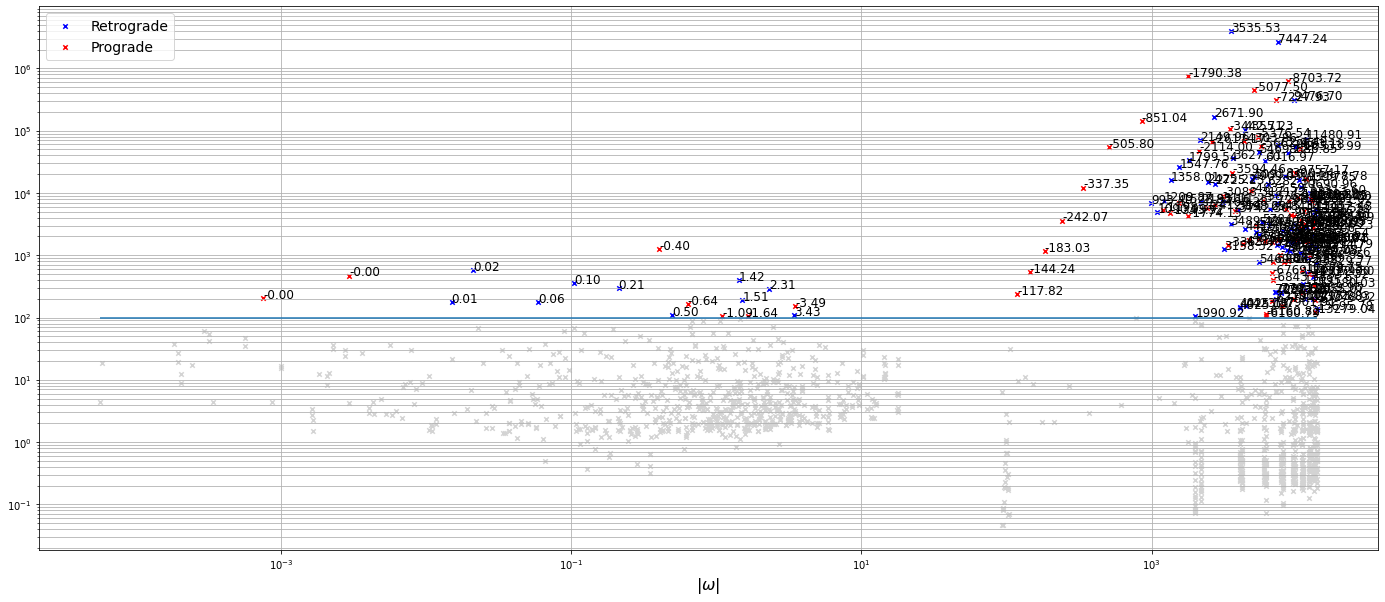

In [13]:
eig_base, eig_comp = eig_vals[1], eig_vals[2]
drift, nearest_idx = pgpy_utils.eigen_drift(eig_base, eig_comp)

fig, ax = plt.subplots(figsize=(24, 10))

threshold = 1e+2
reciproc = 1./drift
idx = np.arange(drift.size)

# ax.scatter(idx[reciproc > threshold], reciproc[reciproc > threshold], 20, color='b', marker='x')
# ax.scatter(idx[reciproc <= threshold], reciproc[reciproc <= threshold], 20, color='k', marker='x')
# for idx_tmp in idx[reciproc > threshold]:
#     ax.annotate("{:.2f}".format(eig_vals[1][idx_tmp]), (idx_tmp, reciproc[idx_tmp]))
# ax.hlines([threshold,], idx[0] - 1, idx[-1] + 1)
# ax.set_xlim([idx[0] - 1, idx[-1] + 1])

idx_pos = eig_base.imag >= 0
idx_neg = eig_base.imag < 0

ax.scatter(np.abs(eig_base[(reciproc > threshold) & idx_pos].imag), reciproc[(reciproc > threshold) & idx_pos], 20, color='b', marker='x', label="Retrograde")
ax.scatter(np.abs(eig_base[(reciproc > threshold) & idx_neg].imag), reciproc[(reciproc > threshold) & idx_neg], 20, color='r', marker='x', label="Prograde")
ax.scatter(np.abs(eig_base[reciproc <= threshold].imag), reciproc[reciproc <= threshold], 20, color='lightgray', marker='x')
for idx_tmp in idx[reciproc > threshold]:
    ax.annotate("{:.2f}".format(eig_base[idx_tmp].imag), (np.abs(eig_base[idx_tmp].imag), reciproc[idx_tmp]), fontsize=12)
ax.hlines([threshold,], np.abs(eig_base.imag).min(), np.abs(eig_base.imag).max())
ax.legend(fontsize=14)

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim([np.abs(eig_base.imag).min(), np.abs(eig_base.imag).max()])
# ax.set_xlim([10, np.abs(eig_base.imag).max()])
ax.set_xlabel(r"$|\omega|$", fontsize=16)
ax.grid(which="both")

plt.show()

Output

In [19]:
import h5py

with h5py.File("./out/S1_ideal__eigenspec_m3.h5", 'x') as fwrite:
    for i_res, res in enumerate(resolutions):
        gp = fwrite.create_group(f"eigenspec_res{i_res}")
        gp.attrs["L"] = res[0]
        gp.attrs["N"] = res[1]
        gp.attrs["m"] = res[2]
        gp.create_dataset("spectrum", data=eig_vals[i_res])

### Calculate eigenmodes for selected eigenvalues

Can we really afford to calculate all eigenvectors corresponding to the full spectrum? (Also is it necessary?)

In [3]:
tools.print_heading(f"Calculating selected eigenmodes for m = {m_val}, Le = {Le:.3e}", prefix='\n', suffix='\n', lines="over", char='=')

res = (51, 51, m_val)
nr, maxnl, m = res
print(f"Resolution (L, N)=({maxnl}, {nr})")

eig_targets = [
    -1790.j,
    -851.j,
    -506.j,
    -337.j,
    -241.j,
    -182.j,
    -142.j,
    +3535.j
]
eig_vals_selected = list()
eig_vecs_selected = list()

with utils.Timer("Build operator"):

    bg_modes = [poly.SphericalHarmonicMode("pol", 1, 0, "r(3r^2 - 5)")]
    mod = mod_setup_MC(nr, maxnl, m)
    A, B = mod.setup_operator(
        field_modes=bg_modes, setup_eigen=True, lehnert=Le
    )

print(f"K shape: {A.shape[0]}x{A.shape[1]}\n"
      f"M shape: {B.shape[0]}x{B.shape[1]}")


for i_target, target in enumerate(eig_targets):
    with utils.Timer(f"Calculating near lambda={target}"):
        w, v = utils.single_eig(A, B, target, nev=1)
    eig_vals_selected.append(w)
    eig_vecs_selected.append(v)

del A, B


Calculating selected eigenmodes for m = 3, Le = 1.414e-04

Resolution (L, N)=(51, 51)
Build operator elapsed 7.25 s.
K shape: 9696x9696
M shape: 9696x9696
Calculating near lambda=(-0-1790j) elapsed 0.72 s.
Calculating near lambda=(-0-851j) elapsed 0.60 s.
Calculating near lambda=(-0-506j) elapsed 0.59 s.
Calculating near lambda=(-0-337j) elapsed 0.59 s.
Calculating near lambda=(-0-241j) elapsed 0.59 s.
Calculating near lambda=(-0-182j) elapsed 0.58 s.
Calculating near lambda=(-0-142j) elapsed 0.60 s.
Calculating near lambda=3535j elapsed 0.58 s.


In [4]:
eig_vals_selected

[array([-5.41623099e-14-1790.38241107j]),
 array([-5.47869359e-16-851.04596179j]),
 array([5.08283225e-15-505.80402095j]),
 array([-1.04203116e-13-337.36807074j]),
 array([2.02013547e-13-242.1061898j]),
 array([-4.91086584e-13-183.10372479j]),
 array([1.01405751e-12-144.36031772j]),
 array([4.08090904e-15+3535.53174286j])]

## Mode visualization

In [9]:
from operators.worland_transform import WorlandTransform
from operators.associated_legendre_transform import AssociatedLegendreTransformSingleM
from fields import VectorFieldSingleM

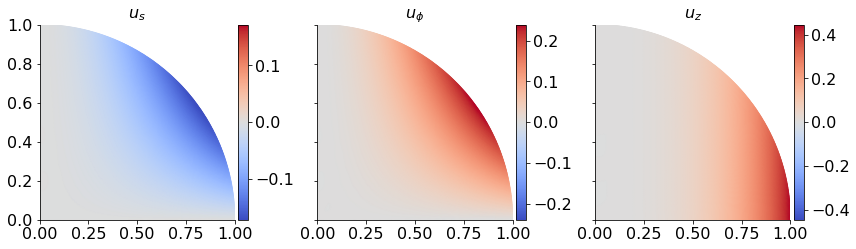

In [18]:
v = eig_vecs_selected[7]

# get spectrum object and normalise to b with energy 1
# dim = v.shape[0] // 2
usp = VectorFieldSingleM(nr, maxnl, m_val, v[:mod.dim['u'], 0])
# bsp = VectorFieldSingleM(nr, maxnl, m_val, v[dim:, 0])
norm = np.sqrt(usp.energy)
usp.normalise(norm)
# bsp.normalise(norm)

# compute physical field on a meridional slice
rg = np.linspace(0, 1, 201)
tg = np.linspace(0, np.pi/2, 201)
worland_transform = WorlandTransform(nr, maxnl, m, r_grid=rg)
legendre_transform = AssociatedLegendreTransformSingleM(maxnl, m, tg)

uphy = usp.physical_field(worland_transform, legendre_transform)
# bphy = bsp.physical_field(worland_transform, legendre_transform)

# visualise field components
fig, axes = plt.subplots(figsize=(12, 8), ncols=3, nrows=1, sharey=True, sharex=True)
uphy.visualise(name='u', coord='cylindrical', ax=axes)
# bphy.visualise(name='b', coord='spherical', ax=axes[1])
fig.tight_layout()

## Misc. testings

### Reciprocal eigenvalue drift:

In [12]:
w1 = np.array([1., 2., 3., 4., 5., 6., 7., 8.])
w2 = np.array([1.0001, 2.5, 2.6, 2.65, 2.7, 4.0001, 6.6, 7.2, 7.9999, 9.])

tools.print_heading("Testing the reciprocal eigenvalue drift...", suffix='\n', lines="over")
print("w1: {}\nw2: {}\n".format(w1, w2))
print("MCModes utils.reciprocal:\n{}\n".format(utils.reciprocal(w1, w2)))
print("PlesioGeostroPy numerics.utils.eigen_drift:\n{}\n".format(
    1/pgpy_utils.eigen_drift(w1, w2)[0]))

Testing the reciprocal eigenvalue drift...

w1: [1. 2. 3. 4. 5. 6. 7. 8.]
w2: [1.0001 2.5    2.6    2.65   2.7    4.0001 6.6    7.2    7.9999 9.    ]

MCModes utils.reciprocal:
[5.00000000e+03 1.00000000e+00 5.00000000e+00 2.50000000e+04
 2.18750000e+00 3.75000000e+00 5.50055006e+00]

PlesioGeostroPy numerics.utils.eigen_drift:
[1.00000000e+04 2.00000000e+00 3.33333333e+00 1.00000000e+04
 1.00010001e+00 1.66666667e+00 5.00000000e+00 1.00000000e+04]

